# Processamento de Imagem e Visão
## Trabalho Prático 2
### Alunos: Belarmino Sacate (52057) e Miguel Ferreira (51878)

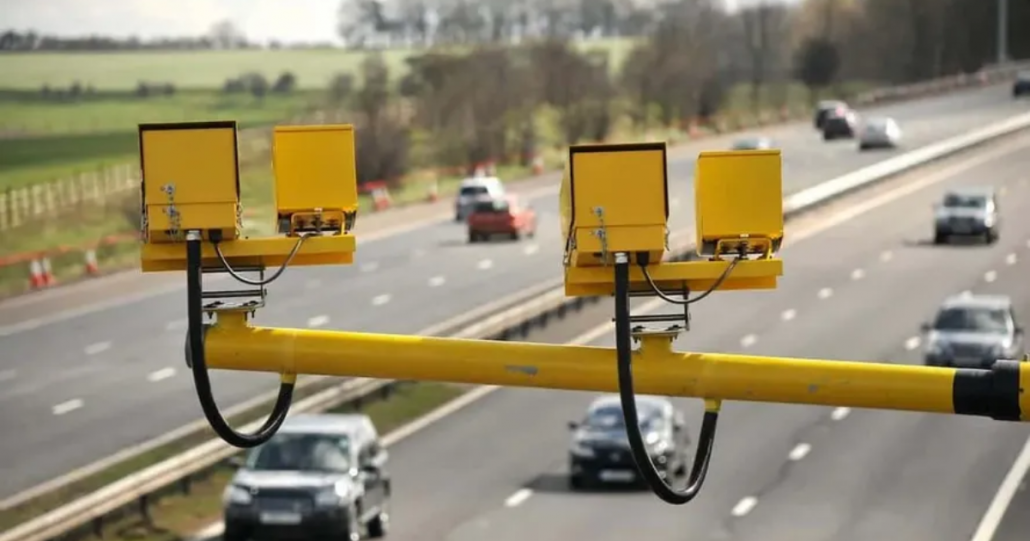

------
# 1. INTRODUÇÃO

Este trabalho foi desenvolvido no âmbito da unidade curricular de Processamento de Imagem e Visão com o objetivo de desenvolver uma aplicação que a partir de um video, conte e meça a velocidade de veículos numa autoestrada. 

O trabalho é baseado em conceitos fundamentais do processamento de imagem, como a subtração do fundo, operações morfológicas, deteção de contornos e "tracing" de objetos. Foi utilizada a biblioteca OpenCV, uma ferramenta conhecida e usada em projetos desta área.

O video fornecido apresenta uma autoestrada com três faixas, filmada de um ponto de vista elevado. O objetivo principal é desenvolver um algoritmo que seja capaz de:

- Detetar veículos em movimento nas três faixas

- "Tracing" de veículos ao longo do vídeo

- Contar o número total de veículos que passam

- Estimar a velocidade de cada veículo e a média de velocidade em cada faixa

-------------
# 2. METODOLOGIA

-------------
## 2.1. BIBLIOTECAS

Para o desenvolvimento deste trabalho, foram utilizadas as seguintes bibliotecas Python:

- **OpenCV**: Biblioteca principal para processamento de imagem e visão computacional

- **numpy**: Biblioteca para operações matemáticas e arrays

In [7]:
import cv2
import numpy as np

------------
## 2.1. VARIÁVEIS

As variáveis utilizadas no projeto foram escolhidas após testes e da análise do video fornecido:

- **area_minima_carro = 150**: Área mínima (pixels) para considerar um contorno como veículo. Este valor foi determinado experimentalmente para eliminar ruído e pequenos artefactos, garantindo que apenas objetos grandes o suficiente sejam detetados como veículos. O valor é relativamente pequeno devido à necessidade de detetar veículos quando estes já estão longe da camera.

- **limiar_distancia = 60**: Distância máxima (pixels) para associar uma deteção de um veículo ao mesmo da frame anterior. Este valor foi escolhido para garantir que os veículos mais rápidos não sejam detetados como diferentes.

- **historico_fundo = 40**: Número de frames utilizadas para construir o modelo de fundo através da mediana. Este valor garante uma representação equilibrada da cena sem comprometer o tempo de processamento. Foi escolhido por ser um valor bom o suficiente para garantir uma boa representação do fundo sem consumir muitos recursos.

- **fps = 25.0**: Taxa de frames por segundo utilizada para calcular o tempo decorrido entre elas. Foi escolhida por ser perto da taxa de frames de 23.97 do video.

- **pixels_por_metro = 5**: Estimação das dimensões em pixéis para um metro no video. Este valor foi escolhido experimentalmente para garantir valores razoáveis das velocidades.

- Dicionários (**veiculos_detetados_1**, **veiculos_detetados_2**, **veiculos_detetados_3**) que guardam as deteções de veículos em cada faixa e (**outros_veiculos_1**, **outros_veiculos_2**, **outros_veiculos_3**) que guardam as deteções de veículos noutras faixas para não haver sobrecontagem dos mesmos.

- Listas para armazenar velocidades instantâneas em cada faixa (**faixa1**, **faixa2**, **faixa3**)

- Contador (**id_veiculos_contador**) para atribuir IDs únicos e sequênciais a cada veículo

In [8]:
ficheiro_video = 'Vídeo - Enunciado A.avi'

# parâmetros
area_minima_carro = 150
limiar_distancia = 60
historico_fundo = 40

# estados
veiculos_detetados_1 = {} 
veiculos_detetados_2 = {}  
veiculos_detetados_3 = {}   

# veiculos noutras faixas
outros_veiculos_1 = {}
outros_veiculos_2 = {}
outros_veiculos_3 = {}

# contador ids
id_veiculos_contador = 0

# velocidade
fps = 25.0
pixels_por_metro = 5

# velocidades de cada faixa
faixa1 = []
faixa2 = []
faixa3 = []

As regiões de interesse (ROI) foram definidas manualmente para delimitar as três faixas da autoestrada. Estas são todas retangulares e adequadas à perspetiva da camara.

In [9]:
# pts = [[25, 214],
#        [97, 85],
#        [158, 85],
#        [218, 231]]

# roi pontos
pts1 = [[24, 217], [78, 237], [114, 82], [99, 79]]
pts2 = [[83, 235], [145, 238], [134, 84], [118, 84]]
pts3 = [[152, 237], [138, 82], [155, 79], [218, 232]]

# array dos pontos
roi_selecionada_1 = np.array(pts1, dtype=np.int32)
roi_selecionada_2 = np.array(pts2, dtype=np.int32)
roi_selecionada_3 = np.array(pts3, dtype=np.int32)

------------
## 2.2. MÉTODOS

### 2.2.1. Extração do modelo de fundo
A extração do modelo de fundo é uma fundamental para a detecção de veículos. Para isso utiliza-se um número fixo de frames, que são selecionados de forma uniforme, através do cálculo do intervalo associado ao número de frames, ao longo do vídeo, garantindo um fundo reprodusível. O cálculo da mediana feito posteriormente permite remover os objetos em movimento, que são considerados "outliers".

Esta forma de extrair o fundo contribui para a aceleração do algoritmo, já que recorre ao uso de um número fixo de frames. Também permite obter um fundo fidedigno graças ao uso do intervalo definido e remove objetos em movimento com eficácia.

In [10]:
def obter_fundo(caminho_video, num_frames=50): 

    random_seed = np.random.seed(np.random.randint(0, 100))
    print(random_seed)

    # lista
    frames = []

    video = cv2.VideoCapture(caminho_video)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) # numero total de frames
    
    # escolhe frames aleatorios
    #random_frames = np.random.randint(0, total_frames, num_frames)

    # escolhe frames espaçadas igualmente
    intervalo = max(total_frames//num_frames, 1)

    for indice in range(0, total_frames, intervalo):
        # ler frames do video
        video.set(cv2.CAP_PROP_POS_FRAMES,indice)
        _, frame = video.read()
        frames.append(frame) # adiciona frame à lista
            
    video.release()
    
    # se nao houver frames
    if frames==[]:
        print("Falha ao ler frames para o modelo de fundo")

    # faz a mediana de todas as frames escolhidas (objetos que se movem são removidos)
    fundo = np.median(frames,axis=0).astype(dtype=np.uint8)

    print("Fundo gerado")
    return fundo

A deteção de movimento é realizada através da subtração de fundo e binarização da imagem resultante. Para isto utiliza-se **cv2.absdiff** para calcular a diferença absoluta entre a frame atual e o modelo de fundo, obtendo os objetos em movimento. De seguida aplica-se um limiar de 30 para converter a imagem de diferença numa máscara binária.
Para chegar ao valor do limiar foi feito um teste experimental variando o valor do limiar e observando o resultado. Um limiar baixo (<20) resultava em muitos falsos positivos devido a pequenas variações de ruído ou illuminação. Um limiar alto (>60) tinha alguns problemas em detetar veículos com cores parecidas ao fundo.

In [11]:
def detetar_movimento(frame_cinza, fundo_cinza):
    # diferenca entre imagem e o fundo
    diferenca = cv2.absdiff(frame_cinza, fundo_cinza)

    # aplica threshold para binarizar
    _, binario = cv2.threshold(diferenca,30,255,cv2.THRESH_BINARY)
    return binario

Para refinar a máscara binária, foram aplicados alguns operadores morfológicos para eliminar ruído e preencher boracos que apareciam em alguns veículos detetados.

Foram aplicados os seguintes operadores morfológicos:

- **MORPH_CLOSE:** Aplicou-se um fecho morfológico com kernel 7x7. Esta operação foi usada para fechar boracos dentro dos veículos, conectar partes que pertencem ao mesmo veículo e suavizar os contornos dos objetos.

- **DILATE:** Aplicou-se uma dilatação com kernel 5x5 para expandir ligeiramente os objetos, compensando as alterações feitas com o operador MORPH_CLOSE, garantindo que todo o veículo é capturado.

Finalmente, foi aplicada a máscara da região de interesse (ROI) para delimitar a deteção às áreas para cada faixa definidas anteriormente.

In [12]:
def operadores_morfologicos(mascara_binaria, roi):
    
    kernel = np.ones((5,5), np.uint8)
    #kernel_ = np.ones((3,3), np.uint8)

    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    # kernel4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    
    # operador MORPH_CLOSE
    mascara = cv2.morphologyEx(mascara_binaria, cv2.MORPH_CLOSE, kernel3)

    # dilatação
    mascara = cv2.dilate(mascara, kernel)
    
    # máscara da ROI
    mascara_roi = np.zeros_like(mascara)
    cv2.fillPoly(mascara_roi, [roi],255)

    # aplicar máscara da ROI
    mascara_processada = cv2.bitwise_and(mascara, mascara_roi)
    
    return mascara_processada

A deteção dos veículos é feita através da deteção de contornos na máscara processada. Para isso é utilizado a função **cv2.findContours()** com os parâmetros cv2.RETR_EXTERNAL e cv2.CHAIN_APPROX_SIMPLE. Estas escolhas são ideias para detetar o contorno mais externo no objeto, bem como, simplificar o contorno obtido que ajuda na eficiência do algoritmo.

Para cada contorno detetado são extraidas informações sobre a área, o retângulo envolvente e o centro do veículo. Com base nestas informações é possível filtrar os contornos que não correspondem a veículos. Assim usando a variável **area_minima_carro** 
conseguimos eliminar ruído e artefactos residuais que não são grandes o suficiente para serem considerados veículos.

In [13]:
def detetar_veiculos(mascara_processada, area_minima):
    
    contornos, _ = cv2.findContours(mascara_processada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    detecoes = []
    for contorno in contornos:

        #contorno
        area=cv2.contourArea(contorno)
 
        # comparar areas
        if area > area_minima:

            # calcular informacao do carro
            x, y, w, h = cv2.boundingRect(contorno)
            centro_x, centro_y = x + w // 2, y + h // 2
            detecoes.append((centro_x, centro_y, x, y, w, h))

    return detecoes

A deteção de veículos ao longo do vídeo fornecido, e a estimação da sua velocidade é uma das partes mais fundamentais deste trabalho, pelo que é necessário seguir cada veículo diferente ao longo de frames consecutivas.

O sistema implementa um algoritmo baseado na proximidade entre objetos em frames consecutivas, bem como, calcula a velocidade de cada veículo a partir do seu deslocamento. Se a distância entre dois veículos em frames consecutivos for inferior a um limiar (**limiar_distancia = 60**), considera-se que é o mesmo veículo e evita de criar IDs novos para veículos que já foram detetados.

De seguida dá-se a atribuição de IDs sequenciais, através de um contador, a cada veículo detetado. Cada veículo detetado pode ser considerado como um veículo novo, um veículo previamente detetado na faixa atual (**historico_veiculos**) ou numa das outras faixas (**outros_veiculos**), o que permite seguir os carros quando mudam de faixa ou quando intersetam outra faixa.

Assim, quando um veículo é detetado com sucesso, os seus dados são atualizados ou adicionados ao dicionário historico_veiculos, onde se guarda o ID do veículo, as coordenadas do centro do veículo e a velocidade instantânea.

A velocidade é calculada a partir do deslocamento do centro do veículo entre frames consecutivas convertendo a distância em metros, considerando a variável **pixels_por_metro = 5** e dividindo pelo intervalo de tempo entre frames, considerando a variável **fps = 25**, sendo a velocidade final dada em km/h. Esta também é adicionada ao dicionário de velocidades da faixa correspondente para calcular, posteriormente, a média de velocidade de todos os veículos na faixa.

In [14]:
def atualizar_detecao(detecoes_atuais, historico_veiculos, limiar_distancia, contador_global_id, faixa,outros_veiculos):
    veiculos_novos = {}
    detecoes_id = []
    
    novo_contador_global_id = contador_global_id 
    
    # para todas as detecoes já registadas
    for centro_x, centro_y, x, y, w, h in detecoes_atuais:
        id_atual = -1
        velocidade = 0

        # se não encontrado noutra faixa, verificar se o veiculo ja esta registado na faixa atual
        for vid,dados in historico_veiculos.items():
            centro_x2, centro_y2 = dados['centro']
            
            # diferenca entre os centros
            distancia = np.sqrt((centro_x - centro_x2)**2 + (centro_y - centro_y2)**2)

            if distancia < limiar_distancia:
                id_atual = vid
                
                # velocidade
                distancia_m = distancia / pixels_por_metro
                tempo = 1.0 / fps
                velocidade = (distancia_m / tempo) * 3.6

                # velocidade por faixa
                if faixa == 1:
                    faixa1.append(velocidade)
                elif faixa == 2:
                    faixa2.append(velocidade)
                elif faixa == 3:
                    faixa3.append(velocidade)

                # registar no novo dicionario
                veiculos_novos[id_atual] = {
                    'centro': (centro_x, centro_y),
                    'velocidade': velocidade
                }
                break

        # ver se já existe noutra faixa
        # verificar se o veiculo ja esta registado noutra faixa
        if id_atual == -1:
            for vid, dados in outros_veiculos.items():
                centro_x2, centro_y2 = dados['centro']
                distancia = np.sqrt((centro_x - centro_x2)**2 + (centro_y - centro_y2)**2)

                if distancia < limiar_distancia:
                    id_atual = vid
                    velocidade = dados.get('velocidade', 0)
                    # registar no novo dicionario para manter tracking entre frames/faixas
                    veiculos_novos[id_atual] = {
                        'centro': (centro_x, centro_y),
                        'velocidade': velocidade
                    }
                    break
            
            # se não foi encontrado no historico, criar novo ID
            if id_atual == -1:
                novo_contador_global_id = novo_contador_global_id + 1
                id_atual = novo_contador_global_id

                # registar veiculo novo
                veiculos_novos[id_atual] = {
                    'centro': (centro_x, centro_y),
                    'velocidade': 0
                }
        
        detecoes_id.append((centro_x, centro_y, x, y, w, h, id_atual, velocidade))

    return detecoes_id, veiculos_novos, novo_contador_global_id

Este método foi implementado para a visualização dos resultados sobre o vídeo original, utilizando elementos gráficos para indicar os veículos detectados e as faixas na autoestrada. 

Foi aplicado um retângulo vermelho à volta de um veículo detetado, bem como, um círculo vermelho a indicar o seu centro. Para além disso, foi aplicado um texto em cima do veículo para indicar o seu ID e velocidade.

Finalmente, foi aplicado um polígono verde à volta de cada ROI para indicar a faixa visualmente.

In [15]:
def desenhar_resultados(quadro_visual, deteccoes_com_id, roi_pontos, contagem_total):
    
    for centro_x, centro_y, x, y, w, h, id_atual, vel in deteccoes_com_id:
    
        # retangulo à volta do carro
        cv2.rectangle(quadro_visual,(x, y), (x + w, y + h),(0,0,255),2)
      
        # centro do carro
        cv2.circle(quadro_visual,(centro_x, centro_y), 5,(0,0,255),-1)

        # texto com id e velocidade
        cv2.putText(quadro_visual,f"V{id_atual} {int(vel)}km/h",(x,y-10), cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2)

    # desenhar ROI
    cv2.polylines(quadro_visual,[roi_pontos],True, (0,255,0), 2)
    
    # total dos carros
    # cv2.putText(quadro_visual, f"total: {contagem_total}", (20,40), cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,0), 2)

**EXECUÇÃO PRINCIPAL**

A célula abaixo contém o fluxo de execução dos métodos previamente explicados. A execução principal combina esses métodos de forma a permitir o processamento do vídeo de maneira eficiente, cumprindo assim os objetivos do trabalho.

Primeiro, começamos com a redefinição das variáveis essenciais do processo:

**Dicionários de veículos detectados:** são redefinidos os dicionários responsáveis por armazenar os veículos detetados em cada uma das faixas (veiculos_detectados_1, veiculos_detectados_2 e veiculos_detectados_3).

**Contador global:** a variável id_veiculos_contador é inicializada a 0, sendo esta responsável por enumerar o total de veículos detetados durante o processo.

**Histórico de velocidades:** as listas faixa1, faixa2 e faixa3 são limpas, garantindo que apenas as velocidades registadas na execução atual sejam consideradas.

Estas redefinições são importantes para evitar que dados antigos se acumulem, eliminando assim a necessidade de voltar a executar todas as células anteriores para limpar variáveis que tenham ficado em memória.

Em seguida, é feita a extração da imagem de fundo, que depois é convertida para tons de cinzento de forma a facilitar a deteção de movimento. Após isso, inicializamos o objeto de captura do vídeo que sera fundamental para a leitura sequencial das frames ao longo de todo o processo.

A leitura das frames do vídeo é feita uma a uma, até o fim do vídeo ou até que a tecla "ESC" seja premida. A cada iteração, duas cópias da frame atual são criadas: uma para visualização (quadro_visual) e outra em tons de cinza (quadro_cinza), que é usada no processamento de movimento. Além da aquisição das frames, é também feito o armazenamento dos veículos da iteração anterior nas variáveis veiculos_anteriores_1, veiculos_anteriores_2 e veiculos_anteriores_3, permitindo associar corretamente os veículos já detetados às frames seguintes.

Esta cópia das variáveis dos veículos anteriores é fundamental para a função de "tracking" (atualizar_detecao), pois torna possível correlacionar as posições dos veículos em frames consecutivas, comparando o seu deslocamento e identificando se o veículo permanece na mesma faixa ou se se deslocou para outra.


O processamento das faixas é feito de forma separada. Para cada faixa são efetuados os passos abaixo:

**Deteção de Movimento dos carros:** primeiro, é detetado o movimento, isolando as áreas dinâmicas (áreas que variam em relação ao fundo) da frame atual, comparando com a imagem de fundo.

**Operadores Morfológicos e ROI:** são aplicados operadores morfológicos para eliminar ruídos e restringir o processamento à região de interesse (ROI) de cada faixa.

**Deteção de Veículos:** com a máscara de movimento pronta, são retirados os contornos dos veículos, armazenando características como: centro em X, centro em Y, entre outras (centro_x, centro_y, x, y, w, h).

**Verificação:** para evitar contagens duplicadas de veículos que possam transitar de uma faixa para outra, é realizada a verificação dos veículos das faixas adjacentes. Na função atualizar_detecao, um dos argumentos passados é a junção dos dicionários que armazenam as deteções dos veículos nas faixas adjacentes. Isso é feito utilizando a sintaxe {**veiculos_detetados_x, **veiculos_detetados_y}, que combina os dicionários das faixas x e y num único dicionário. Assim, veículos que possam ter-se deslocado entre faixas são corretamente identificados e a contagem duplicada é evitada.

**Atualização e Tracking:** a função de atualização(atualizar_detecao) associa os veículos recém-detetados aos veículos que já tenham sido monitorizados, ou regista novos veículos, dependendo da proximidade. O contador global de IDs é atualizado conforme necessário.

**Visualização:** para cada faixa, é feito o desenho das caixas de contorno dos veículos detetados, juntamente com os seus identificadores, o ponto central e a respetiva velocidade.

Ao final de cada frame, as estatísticas são atualizadas e exibidas:

**Contagem de veículos:** é apresentado o total de veículos detetados até ao momento.

**Velocidade Média:** é calculada a velocidade média dos veículos em cada faixa, usando os dados das listas de histórico. Se não houver veículos registados numa faixa, a média é 0.

**Exibição de resultados:** a frame é exibida com as caixas de contorno, os identificadores dos veículos e a velocidade média de cada faixa. Além disso, é apresentada uma máscara total, combinando as máscaras das três faixas, para efeitos de depuração.

In [17]:
# reset
veiculos_detetados_1 = {}
veiculos_detetados_2 = {}
veiculos_detetados_3 = {}
id_veiculos_contador = 0
faixa1.clear()
faixa2.clear()
faixa3.clear()

# inicializacao
imagem_fundo = obter_fundo(ficheiro_video, historico_fundo)
fundo_cinza = cv2.cvtColor(imagem_fundo, cv2.COLOR_BGR2GRAY)

captura = cv2.VideoCapture(ficheiro_video)

# loop
while True:
    sucesso, frame = captura.read()

    if not sucesso:
        break 

    quadro_visual = frame.copy()
    quadro_cinza = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # guardar estados anteriores
    veiculos_anteriores_1 = veiculos_detetados_1.copy()
    veiculos_anteriores_2 = veiculos_detetados_2.copy()
    veiculos_anteriores_3 = veiculos_detetados_3.copy()

    # -------------------------------------------------------------------------------------------------------------------

    # AUTO-ESTRADA 1
    
    # Subtração do Fundo
    mascara_1 = detetar_movimento(quadro_cinza, fundo_cinza)
    
    # Operadores Morfologicos e ROI
    mascara_1 = operadores_morfologicos(mascara_1, roi_selecionada_1)
    
    # Deteção de Contornos
    detecoes_atuais_1 = detetar_veiculos(mascara_1, area_minima_carro)

    # Veículos de outras faixas
    outros_veiculos_1 = {**veiculos_detetados_2, **veiculos_detetados_3}
    
    # Atualização da Deteção
    resultados_deteccao_1, novos_veiculos_detetados_1, novo_id_veiculos_contador = atualizar_detecao(detecoes_atuais_1, veiculos_detetados_1, limiar_distancia, id_veiculos_contador, 1, outros_veiculos_1)

    # Atualização do Dicionário
    veiculos_detetados_1 = novos_veiculos_detetados_1
    id_veiculos_contador = novo_id_veiculos_contador

    # Visualização
    desenhar_resultados(quadro_visual, resultados_deteccao_1, roi_selecionada_1, id_veiculos_contador)

    # -------------------------------------------------------------------------------------------------------------------

    # AUTO-ESTRADA 2

    mascara_2 = detetar_movimento(quadro_cinza, fundo_cinza)
    mascara_2 = operadores_morfologicos(mascara_2, roi_selecionada_2)
    detecoes_atuais_2 = detetar_veiculos(mascara_2, area_minima_carro)

    # Usar veículos anteriores + zona 1 já atualizada
    outros_veiculos_2 = {**veiculos_detetados_1, **veiculos_anteriores_3}

    resultados_deteccao_2, novos_veiculos_detetados_2, novo_id_veiculos_contador = atualizar_detecao(detecoes_atuais_2, veiculos_anteriores_2, limiar_distancia, id_veiculos_contador, 2, outros_veiculos_2)

    veiculos_detetados_2 = novos_veiculos_detetados_2
    id_veiculos_contador = novo_id_veiculos_contador

    desenhar_resultados(quadro_visual, resultados_deteccao_2, roi_selecionada_2, id_veiculos_contador)
    
    # -------------------------------------------------------------------------------------------------------------------

    # AUTO-ESTRADA 3

    mascara_3 = detetar_movimento(quadro_cinza, fundo_cinza)
    mascara_3 = operadores_morfologicos(mascara_3, roi_selecionada_3)
    detecoes_atuais_3 = detetar_veiculos(mascara_3, area_minima_carro)

    outros_veiculos_3 = {**veiculos_detetados_1, **veiculos_detetados_2}

    resultados_deteccao_3, novos_veiculos_detetados_3, novo_id_veiculos_contador = atualizar_detecao(detecoes_atuais_3, veiculos_anteriores_3, limiar_distancia, id_veiculos_contador, 3, outros_veiculos_3)

    veiculos_detetados_3 = novos_veiculos_detetados_3
    id_veiculos_contador = novo_id_veiculos_contador
    
    desenhar_resultados(quadro_visual, resultados_deteccao_3, roi_selecionada_3, id_veiculos_contador)

    # -------------------------------------------------------------------------------------------------------------------

    # total dos carros
    cv2.putText(quadro_visual, f"total: {id_veiculos_contador}", (20,40), cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,0), 2)

    # media de velocidade
    if faixa1:
        v_media_1 = np.mean(faixa1)
    else:
        v_media_1 = 0

    if faixa2:
        v_media_2 = np.mean(faixa2)
    else:
        v_media_2 = 0
    
    if faixa3:
        v_media_3 = np.mean(faixa3)
    else:
        v_media_3 = 0
    
    # display
    cv2.putText(quadro_visual, f"v media 1: {np.round(v_media_1,2)}km/h", (140,20), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,255), 1)
    cv2.putText(quadro_visual, f"v media 2: {np.round(v_media_2,2)}km/h", (140,40), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,255), 1)
    cv2.putText(quadro_visual, f"v media 3: {np.round(v_media_3,2)}km/h", (140,60), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,255), 1)

    cv2.imshow("Contagem de Veiculos", quadro_visual)

    mascara_total= np.zeros_like(quadro_cinza)
    mascara_total= (mascara_1 | mascara_2 | mascara_3)

    cv2.imshow("Mascara Total", mascara_total)

    
    # slow down
    if cv2.waitKey(20)==27:
        break

# finalizacao
captura.release()
cv2.destroyAllWindows()
print("Processamento finalizado.")

print("total de veiculos detectados: ", id_veiculos_contador)

None
Fundo gerado
Processamento finalizado.
total de veiculos detectados:  8


------------
# 4. RESULTADOS

A aplicação desenvolvida foi testada no vídeo fornecido e apresentou os seguintes resultados:

O algoritmo detetou e contou com sucesso 13 veículos ao longo de todo o vídeo. Este resultado foi obtido através da deteção de cada veículo e atribuição de IDs únicos bem como evitando contagens duplicadas.

As velocidades médias foram calculadas para cada faixa e apresentadas durante a execução. Os valores variam à medida que os veículos apareçam e saiam de cada faixa.

A aplicação apresenta duas janelas:
- **Contagem e Velocidade de Veículos:** Video com os contornos das deteções, os IDs de cada veículo, as velocidades médias de cada faixa e o contador total dos veículos.
- **Máscara Binária:** Máscara binária combinada das três faixas.

O algoritmo demonstrou ser resistente a mudanças de iluminação e ruído presente no vídeo, foi eficaz na deteção e contagem de veículos, mostrando os resultados em tempo real e foi bastante preciso, com uma taxa baixa de erros.

------------
# 5. CONCLUSÃO

O desenvolvimento deste algoritmo não apenas consolidou, mas também nos permitiu-nos aprimorar conceitos fundamentais de Processamento de Imagem e Visão. A transição da análise de imagens estáticas(TP1) para o processamento de um video(Tp2) exigiu a incorporação de novas abordagens e técnicas. Embora tenha sido possível integrar corretamente conceitos previamente abordados no TP1, como o uso de operadores morfológicos e a extração de componentes conexos, entre outros, este trabalho prático trouxe a necessidade de introduzir novos conceitos, como por exemplo tracking de objetos, que ainda não haviam sido previamente explorados. A combinação dessas metodologias resultou em um sistema eficiente de monitorização de tráfego, no qual a estimação de fundo e o algoritmo de tracking desempenharam papéis cruciais, não só na contagem, mas também no cálculo das velocidades dos veículos.

------------
# 6. BIBLIOGRAFIA

1. OpenCV Documentation. (2024). OpenCV 4.x Documentation. Disponível em: https://docs.opencv.org/
2. Materiais de apoio da unidade curricular de Processamento de Imagem e Visão, ISEL, 2024/2025.